In [1]:
from Simulation.mpc import *
from Simulation.systemFunctions import DistillationColumnAspen
from utils.helpers import *

## Initialize the system

In [2]:
# System and Snapshot paths
path = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\C2S_SS_simulation9.dynf"
path_snaps = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation9"

In [3]:
# First initiate the system
# Nominal Conditions
nominal_conditions =  np.array([1.50032484e+05, -2.10309105e+01, 2.08083248e+01, 6.30485237e-01, 3.69514734e-01, -2.40000000e+01])

# Steady State inputs
ss_inputs = np.array([320000.0, 110.0])

# Sampling time of the system
delta_t = 1 / 6 # 10 mins

In [4]:
# steady state values
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
steady_states={"ss_inputs":dl.ss_inputs,
               "y_ss":dl.y_ss}
print(steady_states)
dl.close(path_snaps)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
{'ss_inputs': array([3.2e+05, 1.1e+02]), 'y_ss': array([  0.1003974 , -22.95514339])}
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation9\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation9\snpA0001.snp


## Loading the system matrices, min max scaling, and min max of the states

In [5]:
dir_path = os.path.join(os.getcwd(), "Data")

In [6]:
# Defining the range of setpoints for data generation
setpoint_y = np.array([[0.002, -26.0],
                       [0.05, -16.0]])
u_min = np.array([300000.0, 100.0])
u_max = np.array([460000, 150.0])

system_data = load_and_prepare_system_data(steady_states=steady_states, setpoint_y=setpoint_y, u_min=u_min, u_max=u_max)

In [7]:
A_aug = system_data["A_aug"]
B_aug = system_data["B_aug"]
C_aug = system_data["C_aug"]

In [8]:
data_min = system_data["data_min"]
data_max = system_data["data_max"]

In [9]:
min_max_states = system_data["min_max_states"]

In [10]:
y_sp_scaled_deviation = system_data["y_sp_scaled_deviation"]

In [11]:
b_min = system_data["b_min"]
b_max = system_data["b_max"]

In [12]:
min_max_dict = system_data["min_max_dict"]

In [14]:
# Setpoints in deviation form
inputs_number = int(B_aug.shape[1])
y_sp_scenario = np.array([[0.013, -23.],
                         [0.018, -22.]])

y_sp_scenario = (apply_min_max(y_sp_scenario, data_min[inputs_number:], data_max[inputs_number:])
                 - apply_min_max(steady_states["y_ss"], data_min[inputs_number:], data_max[inputs_number:]))

n_tests = 200
set_points_len = 200
TEST_CYCLE = [False, False, False, False, False]
warm_start = 10
ACTOR_FREEZE = 10 * set_points_len
warm_start_plot = warm_start * 2 * set_points_len + ACTOR_FREEZE

In [15]:
# # # Observer Gain
# poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
#                   0.01153274, 0.41036367])
# L = compute_observer_gain(A_aug, C_aug, poles)
# L
# # Observer Gain
poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
                  0.5153274, 0.61036367])
# poles = np.array([0.6, 0.6, 0.55, 0.5, 0.5, 0.98, 0.95])
L = compute_observer_gain(A_aug, C_aug, poles)
L

The system is observable.


array([[ 2.61314809e-02, -7.33441464e-04],
       [ 9.57826515e-03,  2.16807172e-01],
       [-6.17077864e-01, -3.83532623e-02],
       [-5.94942729e-04, -5.93262013e-02],
       [-9.27639418e-03, -2.11065507e-01],
       [ 2.13090070e+00,  5.59402571e-02],
       [ 2.09290486e-02,  1.65750104e+00]])

## Setting The hyperparameters for the TD3 Agent

In [16]:
from TD3Agent.agent import TD3Agent
import torch

In [17]:
set_points_number = int(C_aug.shape[0])
STATE_DIM = int(A_aug.shape[0]) + set_points_number + inputs_number
ACTION_DIM = int(B_aug.shape[1])
n_outputs = C_aug.shape[0]
ACTOR_LAYER_SIZES = [512, 512, 512, 512, 512]
CRITIC_LAYER_SIZES = [512, 512, 512, 512, 512]
# ACTOR_LAYER_SIZES = [256, 256, 256]
# CRITIC_LAYER_SIZES = [256, 256, 256]
BUFFER_CAPACITY = 200000
ACTOR_LR = 1e-4
CRITIC_LR = 1e-3
SMOOTHING_STD = 0.02
NOISE_CLIP = 0.05
# EXPLORATION_NOISE_STD = 0.01
GAMMA = 0.995
TAU = 0.005 # 0.01
MAX_ACTION = 1
POLICY_DELAY = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1024
STD_START = 0.04
STD_END = 0.0
STD_DECAY_RATE = 0.99995
STD_DECAY_MODE = "exp"

In [18]:
td3_agent = TD3Agent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    actor_hidden=ACTOR_LAYER_SIZES,
    critic_hidden=CRITIC_LAYER_SIZES,
    gamma=GAMMA,
    actor_lr=ACTOR_LR,
    critic_lr=CRITIC_LR,
    batch_size=BATCH_SIZE,
    policy_delay=POLICY_DELAY,
    target_policy_smoothing_noise_std=SMOOTHING_STD,
    noise_clip=NOISE_CLIP,
    max_action=MAX_ACTION,
    tau=TAU,
    std_start=STD_START,
    std_end=STD_END,
    std_decay_rate=STD_DECAY_RATE,
    std_decay_mode=STD_DECAY_MODE,
    buffer_size=BUFFER_CAPACITY,
    device=DEVICE,
    actor_freeze=ACTOR_FREEZE,
    )

In [19]:
agent_path = r"C:/Users\HAMEDI\OneDrive - McMaster University\PythonProjects\distillationColumnRL\Data\models/agent_2507131207.pkl"
# agent_path = r"C:\Users\HAMEDI\Desktop\DistillRL\Data/models\td3_20251109_192343.pkl"
td3_agent.load(agent_path)

Agent loaded successfully from: C:/Users\HAMEDI\OneDrive - McMaster University\PythonProjects\distillationColumnRL\Data\models/agent_2507131207.pkl


## MPC initialization

In [20]:
# MPC parameters
predict_h = 6
cont_h = 3
b1 = (b_min[0], b_max[0])
b2 = (b_min[1], b_max[1])
bnds = (b1, b2)*cont_h
cons = []
IC_opt = np.zeros(inputs_number*cont_h)
Q1_penalty = 1.
Q2_penalty = 1.
R1_penalty = 1.
R2_penalty = 1.

In [21]:
MPC_obj = MpcSolver(A_aug, B_aug, C_aug,
                    Q1_penalty, Q2_penalty, R1_penalty, R2_penalty,
                    predict_h, cont_h)

# Looking at the inputs in real plant

In [22]:
path_input = r"C:/Users\HAMEDI\OneDrive - McMaster University\Projects\Gans\Data\Input_data.csv"

In [23]:
def preprocess_inputs(path, eth_setpoints_bnds, mode="Cascade"):
    input_df = pd.read_csv(path, low_memory=False)
    columns_to_drop = ["Time step ", "time", "Unnamed: 13", "Unnamed: 14",
                       "Propylene(C3H6)", "Propane (C3H8)", "Methane (CH4)"]
    input_df.drop(columns_to_drop, axis=1, inplace=True)
    input_df.replace('#DIV/0!', np.nan, inplace=True)
    column_names = list(input_df.columns)
    column_names[-1] = 'STREAMS("HXOUT").T'
    column_names[-2] = "TC.SPRemote"
    column_names[-3] = "EAC.SPRemote"
    input_df = pd.DataFrame(input_df.values[1:, :].astype(np.float32), columns=column_names)
    input_df.dropna(inplace=True)
    column_to_move = "TC.SPRemote"
    new_order = [col for col in input_df.columns if col != column_to_move] + [column_to_move]
    input_df = input_df[new_order]
    input_df.iloc[:, 4] = 1.0 - input_df.iloc[:, 3]

    # Initialize the column if it doesn't exist
    if "ETH.SPRemote" not in input_df.columns:
        input_df["ETH.SPRemote"] = np.nan

    # Number of samples to group
    group_size = 400

    # Assigning a random constant value every 50 samples
    for start in range(0, input_df.shape[0], group_size):
        end = start + group_size
        # Generate random number within the bounds
        random_value = np.random.uniform(eth_setpoints_bnds[0], eth_setpoints_bnds[1])
        # Assign this random value to the slice of the DataFrame
        input_df.loc[start:end, "ETH.SPRemote"] = random_value
    if mode == "Cascade":
        input_df.drop(["TC.SPRemote"], axis=1, inplace=True)
    else:
        input_df.drop(["ETH.SPRemote"], axis=1, inplace=True)
    return input_df

In [24]:
import pandas as pd
ETH_SETPOINTS_BNDS = (0.001, 0.006)
mode = "Cascade"
input_df = preprocess_inputs(path_input, ETH_SETPOINTS_BNDS)

In [25]:
input_df.head()

,"STREAMS(""FEED"").FmR","STREAMS(""FEED"").T","STREAMS(""FEED"").P","STREAMS(""FEED"").ZR(""C2H4"")","STREAMS(""FEED"").ZR(""C2H6"")",EAC.SPRemote,"STREAMS(""HXOUT"").T",ETH.SPRemote
0,112007.539062,-19.524258,21.588457,0.627477,0.372523,0.013543,-29.0,0.002534
1,111572.203125,-19.524475,21.595003,0.628583,0.371417,0.013584,-29.0,0.002534
2,110984.531250,-19.539082,21.583118,0.625893,0.374107,0.013573,-29.0,0.002534
3,110887.625000,-19.540548,21.582439,0.628645,0.371355,0.013543,-29.0,0.002534
4,111437.515625,-19.520185,21.584801,0.628713,0.371287,0.013641,-29.0,0.002534


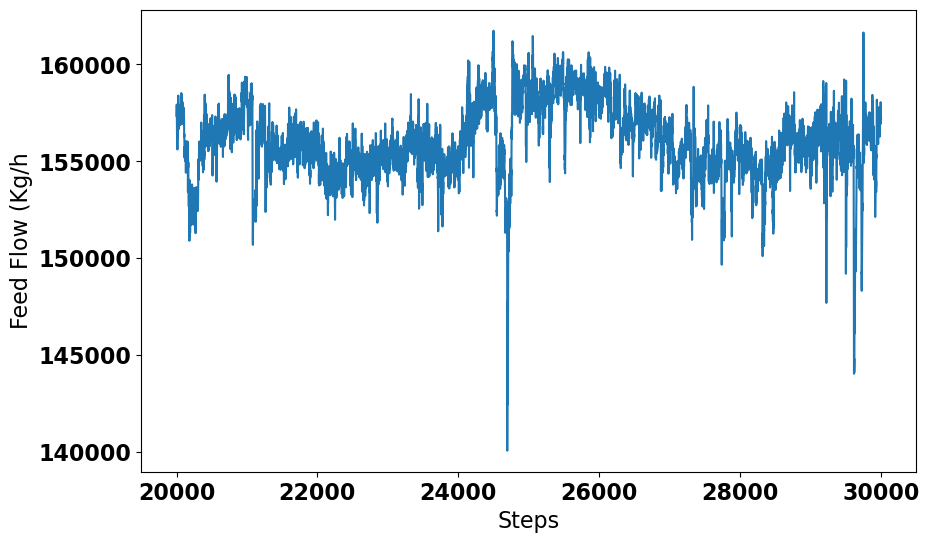

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(input_df["STREAMS(\"FEED\").FmR"].iloc[20000:30000])
plt.xlabel("Steps")
plt.ylabel("Feed Flow (Kg/h")
plt.show()

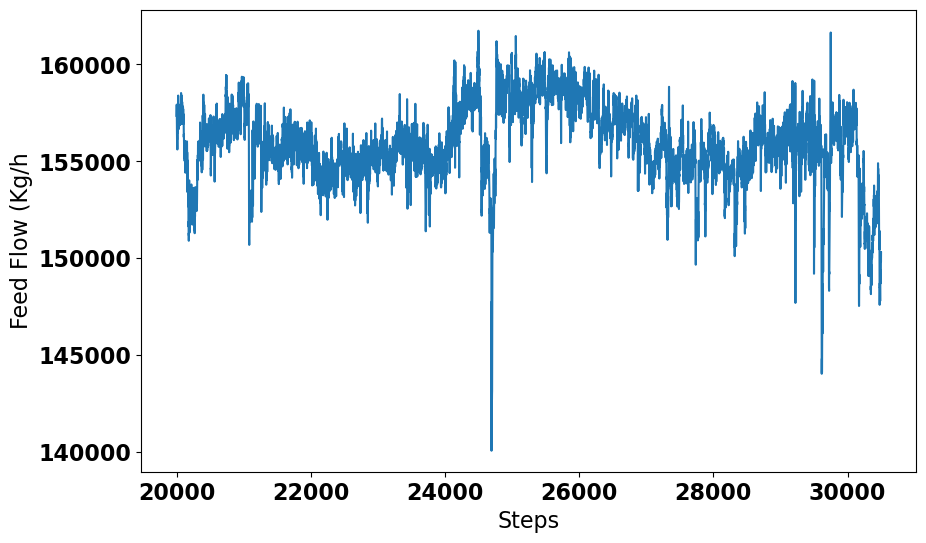

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(input_df["STREAMS(\"FEED\").FmR"].iloc[20000:30500])
plt.xlabel("Steps")
plt.ylabel("Feed Flow (Kg/h")
plt.show()

In [28]:
import numpy as np

def generate_disturbance_sequence(
    total_steps: int,
    nominal: float,
    slow_horizon_range: tuple[int,int],
    slow_std: float,
    slow_offset_bounds: tuple[float,float] | None,
    fast_std: float,
    seed: int | None = None
) -> np.ndarray:
    """
    Generate a disturbance sequence with:
      • piecewise‐constant slow drifts (bounded relative to nominal)
      • small white‐noise jitter in between.

    Parameters
    ----------
    total_steps : int
        Total number of samples.
    nominal : float
        Baseline (e.g. 150_000).
    slow_horizon_range : (int,int)
        Min/max length (in samples) of each slow‐drift segment.
    slow_std : float
        Std‐dev of your underlying slow‐offset distribution.
    slow_offset_bounds : (float,float) or None
        If not None, a (min_offset, max_offset) pair **relative to nominal**;
        any candidate offset outside this window is re-sampled.
    fast_std : float
        Std‐dev of the white noise added at each step.
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    seq : np.ndarray, shape (total_steps,)
        The generated time‐series.
    """
    if seed is not None:
        np.random.seed(seed)

    seq = np.empty(total_steps, dtype=float)
    current = nominal
    idx = 0

    while idx < total_steps:
        # 1) pick how long this slow‐drift segment lasts
        horizon = np.random.randint(*slow_horizon_range)
        horizon = min(horizon, total_steps - idx)

        # 2) sample an offset_target relative to nominal, with rejection
        if slow_offset_bounds is not None:
            lo_off, hi_off = slow_offset_bounds
            offset = np.random.randn() * slow_std
            while offset < lo_off or offset > hi_off:
                offset = np.random.randn() * slow_std
            target = nominal + offset
        else:
            # no bounding: drift relative to current
            drift = np.random.randn() * slow_std
            target = current + drift

        # 3) linear ramp from current → target
        ramp = np.linspace(current, target, horizon)

        # 4) white‐noise jitter
        noise = np.random.randn(horizon) * fast_std

        # 5) store and advance
        seq[idx:idx+horizon] = ramp + noise
        current = target
        idx += horizon

    return seq

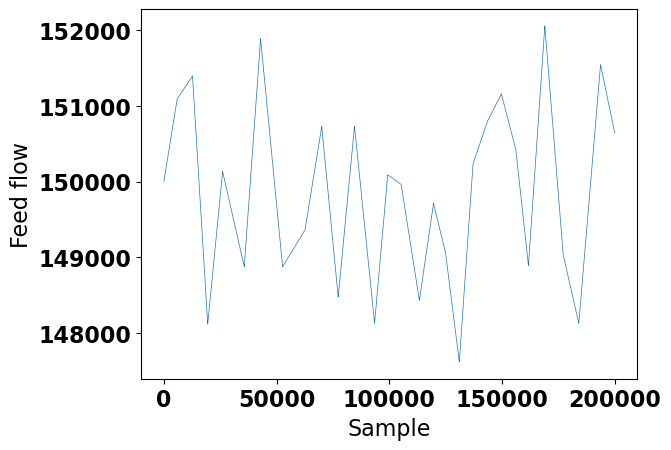

In [29]:
seq = generate_disturbance_sequence(
    total_steps        = 200_000,
    nominal            = 150_000,
    slow_horizon_range = (5_000, 10_000),
    slow_std           = 2_000,
    slow_offset_bounds = (-2_500, +2_500),  # clamp absolute drift to ±5k
    fast_std           = 0,
    seed               = 42
)
plt.plot(seq, lw=0.5)
plt.xlabel("Sample")
plt.ylabel("Feed flow")
plt.show()

## Applying RL Agent on the Distillation column

In [30]:
def make_reward_fn_fixed_QR(
    data_min, data_max, n_inputs,
    y_band_phys,
    Q_diag, R_diag,
    tau_frac=0.5,
    gamma_out=0.20, gamma_in=0.30,
    beta=0.20, gate="geom", lam_in=1.0,
    bonus_kind="exp", bonus_k=8.0, bonus_p=0.6, bonus_c=20.0,
    bonus_scale_mode="qb2",
):

    data_min = np.asarray(data_min, float)
    data_max = np.asarray(data_max, float)
    dy = np.maximum(data_max[n_inputs:] - data_min[n_inputs:], 1e-12)  # phys per scaled

    y_band_phys = np.atleast_1d(np.asarray(y_band_phys, float))
    # convert plant band -> scaled band for this output scaling
    band_scaled = y_band_phys / np.maximum(dy, 1e-12)
    print(band_scaled)
    tau_scaled  = tau_frac * band_scaled

    Q_diag = np.asarray(Q_diag, float)
    R_diag = np.asarray(R_diag, float)

    qb2 = Q_diag * (band_scaled**2)


    def _sigmoid(x):
        x = np.clip(x, -60.0, 60.0)
        return 1.0/(1.0 + np.exp(-x))

    def _phi(z, kind=bonus_kind, k=bonus_k, p=bonus_p, c=bonus_c):
        z = np.clip(z, 0.0, 1.0)
        if kind == "linear":   return 1.0 - z
        if kind == "quadratic":return (1.0 - z)**2
        if kind == "exp":      return (np.exp(-k*z) - np.exp(-k)) / (1.0 - np.exp(-k))
        if kind == "power":    return 1.0 - np.power(z, p)
        if kind == "log":      return np.log1p(c*(1.0 - z)) / np.log1p(c)
        raise ValueError("unknown bonus kind")

    def reward_fn(e_scaled, du_scaled):
        e_scaled = np.asarray(e_scaled, float)
        du_scaled= np.asarray(du_scaled, float)

        # ---- gating computed in *scaled* space (no plant conversion) ----
        abs_e = np.abs(e_scaled)
        s_i   = _sigmoid((band_scaled - abs_e) / np.maximum(tau_scaled, 1e-12))
        if gate == "prod":
            w_in = float(np.prod(s_i, dtype=np.float64))
        elif gate == "mean":
            w_in = float(np.mean(s_i))
        elif gate == "geom":
            w_in = float(np.prod(s_i, dtype=np.float64) ** (1.0/len(s_i)))
        else:
            raise ValueError("gate must be 'prod'|'mean'|'geom'")

        # ---- core MPC-like terms (scaled space) ----
        err_quad = np.sum(Q_diag * (e_scaled**2))
        err_eff  = (1.0 - w_in) * err_quad + w_in * (lam_in * err_quad)   # lam_in=1 -> no relief
        move     = np.sum(R_diag * (du_scaled**2))

        # ---- linear penalties calibrated by slope at the band edge ----
        # slope_i at |e|=b_i is 2 * Q_i * b_i  (same units as derivative of quadratic)
        slope_at_edge = 2.0 * Q_diag * band_scaled

        # outside: penalize only the overflow above the band
        overflow = np.maximum(abs_e - band_scaled, 0.0)
        lin_out  = (1.0 - w_in) * np.sum(gamma_out * slope_at_edge * overflow)

        # inside: penalize |e| linearly (optionally cap at b for stability)
        inside_mag = np.minimum(abs_e, band_scaled)
        lin_in     = w_in * np.sum(gamma_in * slope_at_edge * inside_mag)

        # ---- sharp inside bonus (dimensionless) using normalized scaled z = |e|/band ----
        z = abs_e / np.maximum(band_scaled, 1e-12)
        phi = _phi(z, kind=bonus_kind, k=bonus_k, p=bonus_p, c=bonus_c)
        bonus = w_in * beta * np.sum(qb2 * phi)

        return -(err_eff + move + lin_out + lin_in) + bonus

    return (
        dict(Q_diag=Q_diag, R_diag=R_diag, band_scaled=band_scaled, tau_scaled=tau_scaled,
             gamma_out=gamma_out, gamma_in=gamma_in, beta=beta, gate=gate, lam_in=lam_in,
             bonus_kind=bonus_kind, bonus_k=bonus_k, bonus_p=bonus_p, bonus_c=bonus_c,
             bonus_scale_mode=bonus_scale_mode),
        reward_fn
    )

## Reward configuration

In [31]:
Q_diag = np.array([90000.0, 30000.0])
R_diag = np.array([100.0, 100.0])

y_band_phys = np.array([10e-4, 0.05])
# y_band_phys = np.array([0.005, 0.1])
print("Band scaled are:")

params, reward_fn = make_reward_fn_fixed_QR(
        data_min, data_max, inputs_number,
        y_band_phys,
        Q_diag, R_diag,
        tau_frac=0.7,
        gamma_out=.7, gamma_in=.7,
        beta=70., gate="geom", lam_in=1.0,
        bonus_kind="exp", bonus_k=12.0, bonus_p=0.6, bonus_c=20.0)
print(params)

Band scaled are:
[0.00187414 0.00280702]
{'Q_diag': array([90000., 30000.]), 'R_diag': array([100., 100.]), 'band_scaled': array([0.00187414, 0.00280702]), 'tau_scaled': array([0.00131189, 0.00196492]), 'gamma_out': 0.7, 'gamma_in': 0.7, 'beta': 70.0, 'gate': 'geom', 'lam_in': 1.0, 'bonus_kind': 'exp', 'bonus_k': 12.0, 'bonus_p': 0.6, 'bonus_c': 20.0, 'bonus_scale_mode': 'qb2'}


## Reward annealing technique

In [33]:
def run_rl_train(system, y_sp_scenario, n_tests, set_points_len,
                 steady_states, min_max_dict, agent, MPC_obj,
                 L, data_min, data_max, warm_start,
                 test_cycle,
                 reward_fn):

    # defining setpoints
    y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes, test_train_dict, WARM_START = generate_setpoints_training_rl(
        y_sp_scenario, n_tests, set_points_len, warm_start, test_cycle)
    
    # inputs and outputs of the system dimensions
    n_inputs = B_aug.shape[1]
    n_outputs = C_aug.shape[0]
    n_states = A_aug.shape[0]
    
    # Scaled steady states inputs and outputs
    ss_scaled_inputs = apply_min_max(steady_states["ss_inputs"], data_min[:n_inputs], data_max[:n_inputs])
    y_ss_scaled = apply_min_max(steady_states["y_ss"], data_min[n_inputs:], data_max[n_inputs:])
    u_min, u_max = min_max_dict["u_min"], min_max_dict["u_max"]

    y_system = np.zeros((nFE + 1, n_outputs))
    y_system[0, :] = system.current_output
    u_rl = np.zeros((nFE, n_inputs))
    yhat = np.zeros((n_outputs, nFE))
    xhatdhat = np.zeros((n_states, nFE + 1))
    # xhatdhat[:, 0] = np.random.uniform(low=min_max_dict["x_min"], high=min_max_dict["x_max"])
    rewards = np.zeros(nFE)
    avg_rewards = []

    delta_y_storage = []

    # alpha mpc annealing and add noised
    alpha = 1.0
    anneal_length = 4000.
    u_min_mpc = np.array([300000.0, 100.0])
    u_max_mpc = np.array([460000, 150.0])

    def update_alpha(ep):
        if ep < WARM_START:
            return 1.0
        k = ep - WARM_START
        frac = min(1.0, k / anneal_length)
        return max(0.0, 1.0 - frac)

    def add_noise_mpc(a_mpc):
        mpc_noise_std = 0.04 * (u_max_mpc - u_min_mpc)
        noise = mpc_noise_std * np.random.uniform(-1., 1., 2).astype(np.float32)
        return np.clip(a_mpc + noise, u_min_mpc, u_max_mpc)

    
    # ----- helper ------
    def map_to_bounds(a, low, high):
        return low + ((a + 1.0) / 2.0) * (high - low)
    def unmap_to_bounds(a, low, high):
        return 2.0 * (a - low) / (high - low) - 1.0

    test = False

    # Disturbances
    dist = generate_disturbance_sequence(
        total_steps=nFE,
        nominal=1.50032484e+05,
        slow_horizon_range=(5_000, 10_000),
        slow_std=2_000,
        slow_offset_bounds=(-2_500, +2_500),
        fast_std=0,
        seed=42
    )

    for i in range(nFE):

        # train/test phase
        if i in test_train_dict:
            test = test_train_dict[i]

        # Current scaled input & deviation
        scaled_current_input = apply_min_max(system.current_input, data_min[:n_inputs], data_max[:n_inputs])
        scaled_current_input_dev = scaled_current_input - ss_scaled_inputs

        # ---- RL state (scaled) ----
        current_rl_state = apply_rl_scaled(min_max_dict, xhatdhat[:, i], y_sp[i, :], scaled_current_input_dev)

        # ---- TD3 action ----
        # turn off explore when mpc action is in place
        explore = (not test) and (alpha <= 1e-6)
        if not test:
            action = agent.take_action(current_rl_state, explore=explore)
        else:
            action = agent.act_eval(current_rl_state)

        # Map to bounds
        u_scaled = map_to_bounds(action, u_min, u_max)

        # scale & step plant
        u_rl[i, :] = u_scaled + ss_scaled_inputs
        u_plant = reverse_min_max(u_rl[i, :], data_min[:n_inputs], data_max[:n_inputs])

        # MPC action only if alpha > 0
        if alpha > 1e-6:
            # Solving MPC optimization problem
            sol = spo.minimize(
            lambda x: MPC_obj.mpc_opt_fun(x, y_sp[i, :], scaled_current_input_dev,
                                          xhatdhat[:, i]), IC_opt, bounds=bnds, constraints=cons)
            # take the first control action (this is in scaled deviation form)
            u_mpc = sol.x[:MPC_obj.B.shape[1]] + ss_scaled_inputs

            u_rl[i, :] = alpha * u_mpc + (1 - alpha) * u_rl[i, :].copy()

            # u (reverse scaling of the mpc)
            u_mpc = reverse_min_max(u_mpc, data_min[:n_inputs], data_max[:n_inputs])

            u_mpc = add_noise_mpc(u_mpc)

            u_plant = np.clip(alpha * u_mpc + (1 - alpha) * u_plant, u_min_mpc, u_max_mpc)

            # action is different now
            action = apply_min_max(u_plant, data_min[:n_inputs], data_max[:n_inputs])
            action = action - ss_scaled_inputs
            action = unmap_to_bounds(action, u_min, u_max)

            # updating alpha
            alpha = update_alpha(i)

        # delta u cost variables
        delta_u = u_rl[i, :] - scaled_current_input

        # Apply to plant and step
        system.current_input = u_plant
        # Step the system with disturbance included
        system.step(disturbances=np.array([dist[i]]))

        # Record output
        y_system[i+1, :] = system.current_output

        # ----- Observer & model roll -----
        y_current_scaled = apply_min_max(y_system[i+1, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled
        y_prev_scaled = apply_min_max(y_system[i, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled

        # Calculate Delta y in deviation form
        delta_y = y_current_scaled - y_sp[i, :]

        # Calculate the next state in deviation form
        yhat[:, i] = np.dot(MPC_obj.C, xhatdhat[:, i])
        xhatdhat[:, i+1] = np.dot(MPC_obj.A, xhatdhat[:, i]) + np.dot(MPC_obj.B, (u_rl[i, :] - ss_scaled_inputs)) + np.dot(L, (y_prev_scaled - yhat[:, i])).T


        # Reward Calculation
        reward = reward_fn(delta_y, delta_u)

        # Record rewards and delta_y
        rewards[i] = reward
        delta_y_storage.append(np.abs(delta_y))

        # ----- Next state for TD3 -----
        next_u_dev = u_rl[i, :] - ss_scaled_inputs
        next_rl_state = apply_rl_scaled(min_max_dict, xhatdhat[:, i+1], y_sp[i, :], next_u_dev)

        # Episode boundary (treat each setpoint block as an episode end)
        # done = 1.0 if (i + 1) % boundary == 0 else 0.0
        done = 0.0

        # Buffer + train (skip if in test phase)
        if not test:
            agent.push(current_rl_state,
                       action.astype(np.float32),
                       float(reward),
                       next_rl_state,
                       float(done))
            if i >= WARM_START:
                _ = agent.train_step()  # returns loss or None

        # diagnostics at sub-episode boundary
        if i in sub_episodes_changes_dict:
            avg_rewards.append(np.mean(rewards[max(0, i - time_in_sub_episodes + 1): i + 1]))
            print('Sub_Episode:', sub_episodes_changes_dict[i], '| avg. reward:', avg_rewards[-1])
            if hasattr(agent, "_expl_sigma"):
                print('Exploration noise:', agent._expl_sigma)

    # unscale to plant units for plotting
    u_rl = reverse_min_max(u_rl, data_min[:n_inputs], data_max[:n_inputs])

    return y_system, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, delta_y_storage, dist

In [34]:
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
y_system, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, delta_y_storage, dist\
    = run_rl_train(dl, y_sp_scenario, n_tests, set_points_len,
                    steady_states, min_max_dict, td3_agent, MPC_obj,
                    L, data_min, data_max, warm_start,
                    TEST_CYCLE,
                    reward_fn)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
Sub_Episode: 1 | avg. reward: -339.75443823970147
Sub_Episode: 2 | avg. reward: -503.7299583435205
Sub_Episode: 3 | avg. reward: -559.3514872630559
Sub_Episode: 4 | avg. reward: -472.0064977885125
Sub_Episode: 5 | avg. reward: -540.2968139230651
Sub_Episode: 6 | avg. reward: -528.8588803452773
Sub_Episode: 7 | avg. reward: -639.272790041317
Sub_Episode: 8 | avg. reward: -428.9292244254728
Sub_Episode: 9 | avg. reward: -457.1735871261466
Sub_Episode: 10 | avg. reward: -248.3333814738615
Sub_Episode: 11 | avg. reward: -580.7756818862608
Sub_Episode: 12 | avg. reward: -344.22637780477925
Sub_Episode: 13 | avg. reward: -261.64734905612556
Sub_Episode: 14 | avg. reward: -224.37653713422438
Sub_Episode: 15 | avg. reward: -107.10649063732062
Sub_Episode: 16 | avg. reward: -242.48640744085952
Sub_Episode: 17 | avg. reward: -80.77730535436014
Sub_Episode: 18 | avg. rewar

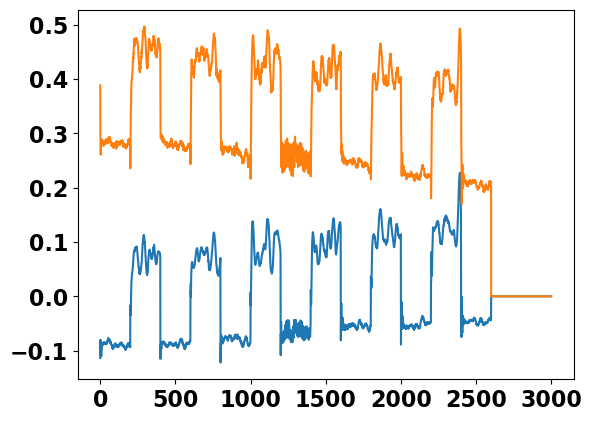

In [35]:
plt.plot(td3_agent.buffer.actions[-123000:-120000])

In [36]:
dl.close(path_snaps)
# TODO different penalties

Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation9\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation9\snpA0001.snp


In [37]:
def plot_rl_results_disturbance(
    y_sp, steady_states, nFE, delta_t, time_in_sub_episodes,
    y_mpc, u_mpc, avg_rewards, data_min, data_max, warm_start_plot,
    directory=None, prefix_name="agent_result",
    agent=None,                 # expects .actor_losses, .critic_losses (lists/arrays)
    delta_y_storage=None,       # list/array of shape (N, 2)
    rewards=None,               # per-step rewards, 1D
    dist=None   # kept for completeness, but not plotted
):
    """
    Plot RL results with warm-start shading; save all inputs + figures
    into directory/prefix_name/<timestamp>. Also plots optional losses,
    delta_y windows, and per-step rewards when provided.
    NOTE: figures are saved only; not shown.
    Returns
    -------
    out_dir : str
        The folder where inputs and figures were saved.
    """
    import os, pickle
    from datetime import datetime
    import numpy as np
    import matplotlib.pyplot as plt

    # ---------- output directory ----------
    if directory is None:
        directory = os.getcwd()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_dir = os.path.join(directory, prefix_name, timestamp)
    os.makedirs(out_dir, exist_ok=True)

    # ---------- helper: save current figure (no show) ----------
    def _savefig(name):
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, name), bbox_inches='tight', dpi=300)
        plt.close()

    # ---------- preserve originals & pack inputs ----------
    y_sp_original = np.array(y_sp, copy=True)  # before conversion

    actor_losses = getattr(agent, "actor_losses", None) if agent is not None else None
    critic_losses = getattr(agent, "critic_losses", None) if agent is not None else None
    dy_arr = np.array(delta_y_storage) if delta_y_storage is not None else None
    rewards_arr = np.array(rewards) if rewards is not None else None

    input_data = {
        "y_sp": y_sp_original,             # original (scaled deviation)
        "steady_states": steady_states,
        "nFE": nFE,
        "delta_t": delta_t,
        "time_in_sub_episodes": time_in_sub_episodes,
        "y_mpc": y_mpc,
        "u_mpc": u_mpc,
        "avg_rewards": avg_rewards,
        "data_min": data_min,
        "data_max": data_max,
        "warm_start_plot": warm_start_plot,
        "actor_losses": actor_losses,
        "critic_losses": critic_losses,
        "delta_y_storage": dy_arr,
        "rewards": rewards_arr,
        "dist": dist,
    }
    with open(os.path.join(out_dir, 'input_data.pkl'), 'wb') as f:
        pickle.dump(input_data, f)

    # ---------- your original plotting code (unchanged logic; save-only) ----------
    # Canceling the deviation form (unchanged logic)
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # -------- visual style only --------
    import matplotlib as mpl
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,    # solid white legend box
    })
    # Distinct, colorblind-safe colors
    C_RL = "tab:blue"
    C_SP = "tab:red"
    C_QC = "tab:green"
    C_QM = "tab:orange"
    C_RW = "tab:purple"

    ####### Plot 1  ###############
    time_plot = np.linspace(0, nFE * delta_t, nFE + 1)
    warm_start_plot = np.atleast_1d(warm_start_plot) * delta_t
    ws_end = float(warm_start_plot.max())

    time_plot_hour = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes + 1)

    from matplotlib.patches import Patch
    import matplotlib.ticker as mtick

    plt.figure(figsize=(10, 8))

    # First subplot
    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot[10:], y_mpc[10:, 0], 'b-', lw=2, label=r'$\mathbf{RL}$', zorder=2)
    ax.step(time_plot[10:-1], y_sp[0, 10:], 'r--', lw=2, label=r'$\mathbf{Setpoint}$', where='post', zorder=3)
    for t_ws in warm_start_plot:
        ax.axvline(t_ws, color='k', linestyle='--', linewidth=1.2, zorder=1)
    ax.axvspan(0.0, ws_end, facecolor='0.9', alpha=0.6, zorder=0)
    ax.set_ylabel(r'$\mathbf{\eta}$ (L/g)', fontsize=18)
    ax.grid(True)
    ax.set_xlim(0, time_plot[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    ax.tick_params(axis='x', pad=4)
    h, l = ax.get_legend_handles_labels()
    ax.legend([Patch(facecolor='0.9', edgecolor='none', label='Warm start')] + h,
              ['Warm start'] + l,
              loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0.,
              frameon=True, fontsize=16)

    # Second subplot
    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot[10:], y_mpc[10:, 1], 'b-', lw=2, label=r'$\mathbf{RL}$', zorder=2)
    ax.step(time_plot[10:-1], y_sp[1, 10:], 'r--', lw=2, label=r'$\mathbf{Setpoint}$', where='post', zorder=3)
    for t_ws in warm_start_plot:
        ax.axvline(t_ws, color='k', linestyle='--', linewidth=1.2, zorder=1)
    ax.axvspan(0.0, ws_end, facecolor='0.9', alpha=0.6, zorder=0)
    ax.set_ylabel(r'$\mathbf{T}$ (K)', fontsize=18)
    ax.set_xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    ax.grid(True)
    ax.set_xlim(0, time_plot[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    ax.tick_params(axis='x', pad=4)
    h, l = ax.get_legend_handles_labels()
    ax.legend([Patch(facecolor='0.9', edgecolor='none', label='Warm start')] + h,
              ['Warm start'] + l,
              loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0.,
              frameon=True, fontsize=16)

    plt.subplot(2, 1, 1); plt.tick_params(axis='both', labelsize=16)
    plt.subplot(2, 1, 2); plt.tick_params(axis='both', labelsize=16)
    plt.gcf().subplots_adjust(right=0.82, bottom=0.12)
    _savefig('fig_rl_outputs_full.png')

    ########### last window (= time_in_sub_episodes) ##########
    plt.figure(figsize=(7.6, 5.2))
    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot_hour, y_mpc[nFE - time_in_sub_episodes:, 0], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_hour[:-1], y_sp[0, nFE - time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$\eta$ (L/g)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot_hour, y_mpc[nFE - time_in_sub_episodes:, 1], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_hour[:-1], y_sp[1, nFE - time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$T$ (K)'); ax.set_xlabel(r'Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig(f'fig_rl_outputs_last{time_in_sub_episodes}.png')

    ########### last 4×window ##########
    plt.figure(figsize=(7.6, 5.2))
    time_plot_4w = np.linspace(0, 4 * time_in_sub_episodes * delta_t, 4 * time_in_sub_episodes + 1)

    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot_4w, y_mpc[nFE - 4 * time_in_sub_episodes:, 0], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_4w[:-1], y_sp[0, nFE - 4 * time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$\eta$ (L/g)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot_4w, y_mpc[nFE - 4 * time_in_sub_episodes:, 1], '-', lw=2.2, color=C_RL, label=r'RL', zorder=2)
    ax.step(time_plot_4w[:-1], y_sp[1, nFE - 4 * time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$T$ (K)'); ax.set_xlabel(r'Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig(f'fig_rl_outputs_last{4*time_in_sub_episodes}.png')

    ####### Plot 2  (inputs) ###############
    plt.figure(figsize=(7.6, 5.2))
    ax = plt.subplot(2, 1, 1)
    ax.step(time_plot[:-1], u_mpc[:, 0], where='post', lw=2.2, color=C_QC, label=r'$Q_c$', zorder=2)
    ax.set_ylabel(r'$Q_c$ (L/h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    ax = plt.subplot(2, 1, 2)
    ax.step(time_plot[:-1], u_mpc[:, 1], where='post', lw=2.2, color=C_QM, label=r'$Q_m$', zorder=2)
    ax.set_ylabel(r'$Q_m$ (L/h)'); ax.set_xlabel(r'Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig('fig_rl_inputs_full.png')

    ############# Plot 3 (Reward per episode) #######################
    plt.figure(figsize=(7.2, 4.2))
    xep = np.arange(1, len(avg_rewards) + 1)
    plt.plot(xep, avg_rewards, 'o-', lw=2.2, color=C_RW, label='Reward per Episode', zorder=2)
    plt.ylabel('Avg. Reward')
    plt.xlabel('Episode #')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.35)
    ax = plt.gca()
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right', framealpha=1.0, facecolor='white')
    _savefig('fig_rl_rewards.png')

    # ---------- optional losses ----------
    if actor_losses is not None and len(actor_losses) > 0:
        plt.figure(figsize=(7.2, 4.2))
        plt.plot(actor_losses, lw=1.8, color='tab:blue')
        plt.ylabel('Actor Loss'); plt.xlabel('Update Step'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('loss_actor.png')

    if critic_losses is not None and len(critic_losses) > 0:
        plt.figure(figsize=(7.2, 4.2))
        plt.plot(critic_losses, lw=1.8, color='tab:orange')
        plt.ylabel('Critic Loss'); plt.xlabel('Update Step'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('loss_critic.png')

    # ---------- optional delta_y windows ----------
    if dy_arr is not None and dy_arr.ndim == 2 and dy_arr.shape[1] >= 2:
        n = dy_arr.shape[0]

        # last 300
        i0 = max(0, n-300); w = dy_arr[i0:n]
        if len(w) > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.plot(w[:, 0], c='r', label=r'$\Delta y_1$')
            plt.plot(w[:, 1], c='b', label=r'$\Delta y_2$')
            plt.ylabel(r'$\Delta y$'); plt.xlabel('Step'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('delta_y_last300.png')

        # slice [-700:-400]
        j0 = max(0, n-700); j1 = max(0, n-400)
        w2 = dy_arr[j0:j1]
        if len(w2) > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.plot(w2[:, 0], c='r', label=r'$\Delta y_1$')
            plt.plot(w2[:, 1], c='b', label=r'$\Delta y_2$')
            plt.ylabel(r'$\Delta y$'); plt.xlabel('Step'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('delta_y_700_400.png')

    # ---------- optional per-step rewards ----------
    if rewards_arr is not None and rewards_arr.ndim == 1 and rewards_arr.size > 0:
        n = rewards_arr.size
        # [-700:-400]
        j0 = max(0, n-700); j1 = max(0, n-400); w = rewards_arr[j0:j1]
        if w.size > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.scatter(range(w.size), w, s=10)
            plt.ylabel('Reward'); plt.xlabel('Step'); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('rewards_700_400.png')

        # last 300
        i0 = max(0, n-300); w2 = rewards_arr[i0:n]
        if w2.size > 0:
            plt.figure(figsize=(7.6, 4.2))
            plt.scatter(range(w2.size), w2, s=10)
            plt.ylabel('Reward'); plt.xlabel('Step'); plt.grid(True, linestyle='--', alpha=0.35)
            _savefig('rewards_last300.png')

        # full
        plt.figure(figsize=(7.6, 4.2))
        plt.scatter(range(rewards_arr.size), rewards_arr, s=10)
        plt.ylabel('Reward'); plt.xlabel('Step'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('rewards_all.png')

    # ---------- disturbance ----------
    if dist is not None:
        plt.figure(figsize=(7.2, 4.2))
        plt.plot(time_plot[10:], dist[9:], lw=1.8, color='tab:blue')
        plt.ylabel('Reflux (Kg/h)'); plt.xlabel('Time (hour)'); plt.grid(True, linestyle='--', alpha=0.35)
        _savefig('feed_dist.png')

    return out_dir

In [38]:
out_dir = plot_rl_results_disturbance(
    y_sp, steady_states, nFE, delta_t, time_in_sub_episodes,
    y_system, u_rl, avg_rewards, data_min, data_max, warm_start_plot,
    directory=dir_path, prefix_name="dl_disturb",
    agent=td3_agent, delta_y_storage=delta_y_storage, rewards=rewards,
    dist=dist
)
print("Saved to:", out_dir)

Saved to: C:\Users\HAMEDI\Desktop\DistillRL\Data\dl_disturb\20251123_131321


In [91]:
min_max_states

{'min_s': array([-0.2, -0.2, -0.5, -0.2, -0.5, -1.5, -2. ]),
 'max_s': array([0.5, 0.5, 1.5, 1. , 0.1, 1. , 1. ])}

In [92]:
np.min(xhatdhat, axis=1)

array([ 0.        ,  0.        , -0.0314628 , -0.03892811, -0.31658996,
       -1.51938217, -1.40420006])

In [93]:
np.max(xhatdhat, axis=1)

array([0.27642639, 0.34681307, 1.45059424, 0.83586224, 0.        ,
       0.        , 0.0770685 ])

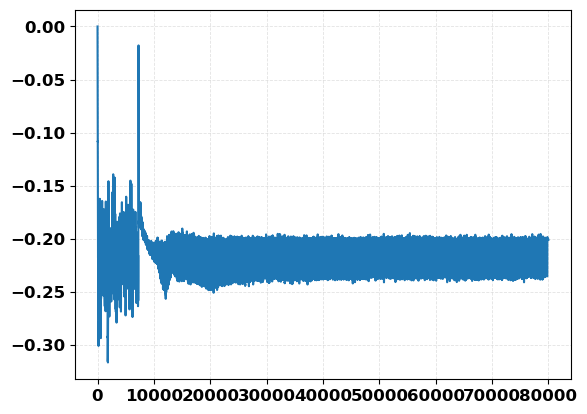

In [94]:
plt.plot(xhatdhat[4, :])

In [95]:
Q_diag = np.array([90000.0, 30000.0])
R_diag = np.array([100.0, 100.0])

y_band_phys = np.array([10e-4, 0.05])
# y_band_phys = np.array([0.005, 0.1])
print("Band scaled are:")

params, reward_fn = make_reward_fn_fixed_QR(
        data_min, data_max, inputs_number,
        y_band_phys,
        Q_diag, R_diag,
        tau_frac=0.7,
        gamma_out=.7, gamma_in=.7,
        beta=70., gate="geom", lam_in=1.0,
        bonus_kind="exp", bonus_k=12.0, bonus_p=0.6, bonus_c=20.0)
print(params)

Band scaled are:
[0.00187414 0.00280702]
{'Q_diag': array([90000., 30000.]), 'R_diag': array([100., 100.]), 'band_scaled': array([0.00187414, 0.00280702]), 'tau_scaled': array([0.00131189, 0.00196492]), 'gamma_out': 0.7, 'gamma_in': 0.7, 'beta': 70.0, 'gate': 'geom', 'lam_in': 1.0, 'bonus_kind': 'exp', 'bonus_k': 12.0, 'bonus_p': 0.6, 'bonus_c': 20.0, 'bonus_scale_mode': 'qb2'}


In [96]:
save_path = os.path.join(dir_path, "mpc_results_200.pickle")
with open(save_path, 'rb') as file:
    mpc_results = pickle.load(file)
y_mpc = mpc_results["y_mpc"]
u_mpc = mpc_results["u_mpc"]
avg_rewards_ = mpc_results["avg_rewards"]
avg_rewards_mpc = mpc_results["avg_rewards_mpc"]
delta_y_storage_mpc = mpc_results["delta_y_storage"]
delta_u_storage_mpc = mpc_results["delat_u_storage"]

In [97]:
y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes, test_train_dict, WARM_START = generate_setpoints_training_rl(
        y_sp_scenario, n_tests, set_points_len, warm_start, TEST_CYCLE)
avg_reward_mpc_ = []

In [98]:
delta_y_storage_mpc = np.array(delta_y_storage_mpc)
delta_u_storage_mpc = np.array(delta_u_storage_mpc)
rewards_mpc_ = np.zeros(len(delta_u_storage_mpc))
for i in range(len(delta_y_storage_mpc)):
    rewards_mpc_[i] = reward_fn(delta_y_storage_mpc[i], delta_u_storage_mpc[i])
    if i in sub_episodes_changes_dict:
        avg_reward_mpc_.append(np.mean(rewards_mpc_[max(0, i - time_in_sub_episodes + 1): i + 1]))

In [99]:
avg_reward_mpc_

[np.float64(-21.881149760733756), np.float64(3.9890489272246668)]

In [100]:
def compare_mpc_rl(y_rl, y_mpc, y_sp, avg_rewards_rl, avg_rewards_mpc,
                   delta_t, directory, prefix_name):
    """
    Plots last-portion comparison (RL vs MPC vs Setpoint) and reward curves.
    Saves to:
      - outputs_compare.(png|pdf)
      - reward_compare.(png|pdf)
    Data logic and inputs remain yours.
    """
    # ---------- output directory ----------
    import os, pickle
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_dir = os.path.join(directory, prefix_name, timestamp)
    os.makedirs(out_dir, exist_ok=True)

    # ---------- helper: save current figure (PNG + PDF; no show) ----------
    import matplotlib.pyplot as plt
    def _savefig(name_png):
        plt.tight_layout()
        full_png = os.path.join(out_dir, name_png)
        plt.savefig(full_png, bbox_inches='tight', dpi=300)
        base, _ = os.path.splitext(full_png)
        plt.savefig(base + '.pdf', bbox_inches='tight')
        plt.close()

    start_idx = -800

    # --- Setpoint back to real units (your convention) ---
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T  # shape (nFE, 2)

    import matplotlib as mpl
    import matplotlib.ticker as mtick
    import numpy as np

    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })

    # Colors/styles (colorblind-safe)
    C_RL = "tab:blue"
    C_MPC = "black"
    C_SP = "tab:red"

    # --- Tail slices (keep your start_idx; align lengths for line vs step) ---
    y_rl_tail  = np.asarray(y_rl[start_idx:, :],  float)    # (L_line, 2)
    y_mpc_tail = np.asarray(y_mpc[start_idx:, :], float)    # (L_line, 2)
    sp_tail    = np.asarray(y_sp[start_idx:, :],  float)    # (2, W_step)

    # Determine aligned window W where step has W and lines have W+1 samples
    L_line = min(y_rl_tail.shape[0], y_mpc_tail.shape[0])
    W_step = sp_tail.shape[1]
    W = min(W_step, L_line - 1)  # ensure consistent time base

    # Crop to aligned sizes
    y_rl_tail  = y_rl_tail[-(W + 1):, :]
    y_mpc_tail = y_mpc_tail[-(W + 1):, :]
    sp_tail    = sp_tail[:, -W:]               # (2, W)

    # Time bases (hours): line has W+1, step has W (post-hold)
    t_line = np.linspace(0, W * delta_t, W + 1)
    t_step = t_line[:-1]

    # ---------------- Outputs compare (last W) ----------------
    fig, axs = plt.subplots(2, 1, figsize=(7.6, 5.2), sharex=True)

    # Tray 23 C2H6 composition
    ax = axs[0]
    ax.plot(t_line, y_rl_tail[:, 0], '-',  lw=2.2, color=C_RL,  label="RL",  zorder=2)
    ax.plot(t_line, y_mpc_tail[:, 0], '--', lw=2.2, color=C_MPC, label="MPC", zorder=2)
    ax.step(t_step, sp_tail[0, :], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label="Setpoint", zorder=3)
    ax.set_ylabel(r'$x_{23,\mathrm{C_2H_6}}$ (–)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(0, t_line[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', pad=4)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0),
              borderaxespad=0., framealpha=1.0, facecolor='white')

    # Tray 85 temperature
    ax = axs[1]
    ax.plot(t_line, y_rl_tail[:, 1], '-',  lw=2.2, color=C_RL,  label="RL",  zorder=2)
    ax.plot(t_line, y_mpc_tail[:, 1], '--', lw=2.2, color=C_MPC, label="MPC", zorder=2)
    ax.step(t_step, sp_tail[1, :], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label="Setpoint", zorder=3)
    ax.set_ylabel(r'$T_{85}$ (K)'); ax.set_xlabel('Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(0, t_line[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', pad=4)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0),
              borderaxespad=0., framealpha=1.0, facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    fig.tight_layout()
    _savefig('outputs_compare.png')

    # ---------------- Rewards: full with outside inset (legend outside) ----------------
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

    fig, ax = plt.subplots(figsize=(7.2, 4.6))

    # main plot
    x_main = np.arange(1, len(avg_rewards_rl))
    ax.plot(x_main, avg_rewards_rl[1:], 'o-', lw=2, ms=4, color='tab:blue',   label='RL')
    ax.hlines(avg_rewards_mpc[-1], xmin=x_main[0], xmax=x_main[-1],
              color='tab:orange', linestyle='--', lw=2, label='MPC')

    ax.set_ylabel('Avg. Reward')
    ax.set_xlabel('Episode #')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(8, integer=True))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))

    # legend OUTSIDE (right)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0),
              borderaxespad=0., frameon=True, facecolor='white')

    # inset: CENTER RIGHT just outside the axes
    axins = zoomed_inset_axes(
        ax, zoom=2.0, loc='center right',
        bbox_to_anchor=(1.02, 0.5),   # outside, vertically centered
        bbox_transform=ax.transAxes,
        borderpad=0.0
    )

    # inset data (same as main)
    axins.plot(x_main, avg_rewards_rl[1:], 'o-', lw=1.8, ms=3.5, color='tab:blue')
    axins.hlines(avg_rewards_mpc[-1], xmin=x_main[0], xmax=x_main[-1],
                 color='tab:orange', linestyle='--', lw=1.8)

    # zoom window (edit these only)
    x1, x2, y1, y2 = 70, 85, 30, 60
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.grid(True, linestyle='--', alpha=0.35)
    axins.spines['top'].set_visible(False); axins.spines['right'].set_visible(False)
    axins.xaxis.set_major_locator(mtick.MaxNLocator(4, integer=True))
    axins.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    axins.tick_params(labelsize=9)

    # box zoom connectors (rectangle + links) — box draws behind lines
    mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.6", lw=1.1)

    # SAVE paper-ready
    _savefig('reward_compare.png')

In [101]:
compare_mpc_rl(y_system, y_mpc, y_sp, avg_rewards, avg_reward_mpc_, delta_t, dir_path, prefix_name="compare_reward_ndist")

C:\Users\HAMEDI\AppData\Local\Temp\ipykernel_66216\1610929490.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [102]:
def compare_mpc_rl_disturbance(y_rl, y_mpc, y_sp, u_mpc, u_rl, avg_rewards_rl, avg_rewards_mpc, time_in_sub_episodes, delta_t):

    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # --- Plot the "last portion" (time_in_sub_episodes) ---
    # Convert those steps to their own time axis
    time_plot_sub = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes)
    start_idx = -400

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.ticker as mtick
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })

    plt.figure(figsize=(10, 8))

    # Subplot 1: last portion, y[:, 0]
    plt.subplot(2, 1, 1)
    plt.plot(time_plot_sub, y_rl[start_idx:, 0], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 0], 'k--', lw=2)
    plt.step(time_plot_sub,
             y_sp[0, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$x_{24,\mathrm{C_2H_6}}$', fontsize=18)
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)

    # Subplot 2: last portion, y[:, 1]
    plt.subplot(2, 1, 2)
    plt.plot(time_plot_sub, y_rl[start_idx:, 1], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 1], 'k--', lw=2)
    plt.step(time_plot_sub,
             y_sp[1, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$T_{85}$ (K)', fontsize=18)
    plt.xlabel(r'Time (hour)', fontsize=18, fontweight='bold')
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)
    #
    # Ticks
    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)
    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()
    

    # Subplot 2: Avg rewards
    plt.figure(figsize=(10, 8))
    avg_rewards_rl = avg_rewards_rl[25:]

    plt.plot(np.arange(1, len(avg_rewards_rl) + 1), avg_rewards_rl, 'bo-', lw=2)
    # plt.plot(np.arange(1, len(avg_rewards_mpc) + 1), avg_rewards_mpc, 'ro-', lw=2, label='Reward MPC per Episode')
    plt.hlines(avg_rewards_mpc[-1], xmin=0, xmax=np.arange(1, len(avg_rewards_rl) + 1)[-1], linestyles='--', lw=2)
    plt.ylabel(r'Avg. Reward', fontsize=16, fontweight='bold')
    plt.xlabel(r'Episode #', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    # plt.hlines(-3.0233827500429884)
    # plt.xticks(np.arange(1, len(avg_rewards) + 1), fontsize=14, fontweight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.legend(loc='best', fontsize=16)
    
    # Subplot 3: Manipulated inputs
    plt.figure(figsize=(10, 8))

    # First subplot
    plt.subplot(2, 1, 1)
    plt.plot(time_plot_sub, u_rl[start_idx:, 0], 'b-', lw=2, label=r'RL')
    plt.plot(time_plot_sub, u_mpc[start_idx:, 0], 'k--', lw=2, label=r'MPC')
    plt.ylabel(r'$\mathbf{R}$ (kg/h)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    # Second subplot
    plt.subplot(2, 1, 2)
    plt.plot(time_plot_sub, u_rl[start_idx:, 1], 'b-', lw=2, label=r'RL')
    plt.plot(time_plot_sub, u_mpc[start_idx:, 1], 'k--', lw=2, label=r'MPC')
    plt.ylabel(r'$\mathbf{Q}_R$ (Gj/h)', fontsize=18)
    plt.xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)

    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

    plt.show()

In [103]:
save_path = os.path.join(dir_path, r"C:\Users\HAMEDI\Desktop\DistillRL\Data\dl_no_disturb\20251111_183417\input_data.pkl")
with open(save_path, 'rb') as file:
    rl_results = pickle.load(file)

In [104]:
y_system = rl_results["y_mpc"]
y_sp = rl_results["y_sp"]
u_rl = rl_results["u_mpc"]
avg_rewards = rl_results["avg_rewards"]
time_in_sub_episodes = rl_results["time_in_sub_episodes"]

In [105]:
save_path = os.path.join(dir_path,
                         r"C:\Users\HAMEDI\Desktop\DistillRL\Data\dl_no_disturb\20250918_114552\input_data.pkl")
with open(save_path, 'rb') as file:
    rl_results_1 = pickle.load(file)
y_system1 = rl_results_1["y_mpc"]

In [106]:
np.concatenate((y_system1[-800:-600], y_system1[-400:-200]), axis=0)

array([[ 1.56504217e-02, -2.23970377e+01],
       [ 1.38260782e-02, -2.27883557e+01],
       [ 1.27385506e-02, -2.30647719e+01],
       [ 1.24257813e-02, -2.31832422e+01],
       [ 1.25541961e-02, -2.32170081e+01],
       [ 1.28528569e-02, -2.32071295e+01],
       [ 1.31324847e-02, -2.31858261e+01],
       [ 1.33278656e-02, -2.31648598e+01],
       [ 1.34571440e-02, -2.31461330e+01],
       [ 1.35201052e-02, -2.31300887e+01],
       [ 1.35449597e-02, -2.31165152e+01],
       [ 1.35268063e-02, -2.31058464e+01],
       [ 1.34791803e-02, -2.30973982e+01],
       [ 1.34188595e-02, -2.30908605e+01],
       [ 1.33579264e-02, -2.30848768e+01],
       [ 1.33014213e-02, -2.30786731e+01],
       [ 1.32620818e-02, -2.30717787e+01],
       [ 1.32196976e-02, -2.30651180e+01],
       [ 1.31642338e-02, -2.30597641e+01],
       [ 1.30994307e-02, -2.30558826e+01],
       [ 1.30335443e-02, -2.30529013e+01],
       [ 1.29702436e-02, -2.30503583e+01],
       [ 1.29089187e-02, -2.30482435e+01],
       [ 1.

In [107]:
y_system1 = np.concatenate((y_system1[-800:-600], y_system1[-400:-200]), axis=0)

In [108]:
def compare_mpc_rl_rl1(y_rl, y_mpc, y_sp, time_in_sub_episodes, delta_t, y_rl2):

    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # --- Plot the "last portion" (time_in_sub_episodes) ---
    # Convert those steps to their own time axis
    time_plot_sub = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes)
    start_idx = -400

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.ticker as mtick
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })

    plt.figure(figsize=(10, 8))

    # Subplot 1: last portion, y[:, 0]
    plt.subplot(2, 1, 1)
    plt.plot(time_plot_sub, y_rl[start_idx:, 0], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 0], 'k--', lw=2)
    plt.plot(time_plot_sub, y_rl2[start_idx:, 0], 'g-', lw=2)
    plt.step(time_plot_sub,
             y_sp[0, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$x_{24,\mathrm{C_2H_6}}$', fontsize=18)
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)

    # Subplot 2: last portion, y[:, 1]
    plt.subplot(2, 1, 2)
    plt.plot(time_plot_sub, y_rl[start_idx:, 1], 'b-', lw=2)
    plt.plot(time_plot_sub, y_mpc[start_idx:, 1], 'k--', lw=2)
    plt.plot(time_plot_sub, y_rl2[start_idx:, 1], 'g-', lw=2)
    plt.step(time_plot_sub,
             y_sp[1, start_idx:],
             'r--', lw=2)
    plt.ylabel(r'$T_{85}$ (K)', fontsize=18)
    plt.xlabel(r'Time (hour)', fontsize=18, fontweight='bold')
    plt.grid(True)
    # plt.legend(loc='best', fontsize=16)
    #
    # Ticks
    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)
    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

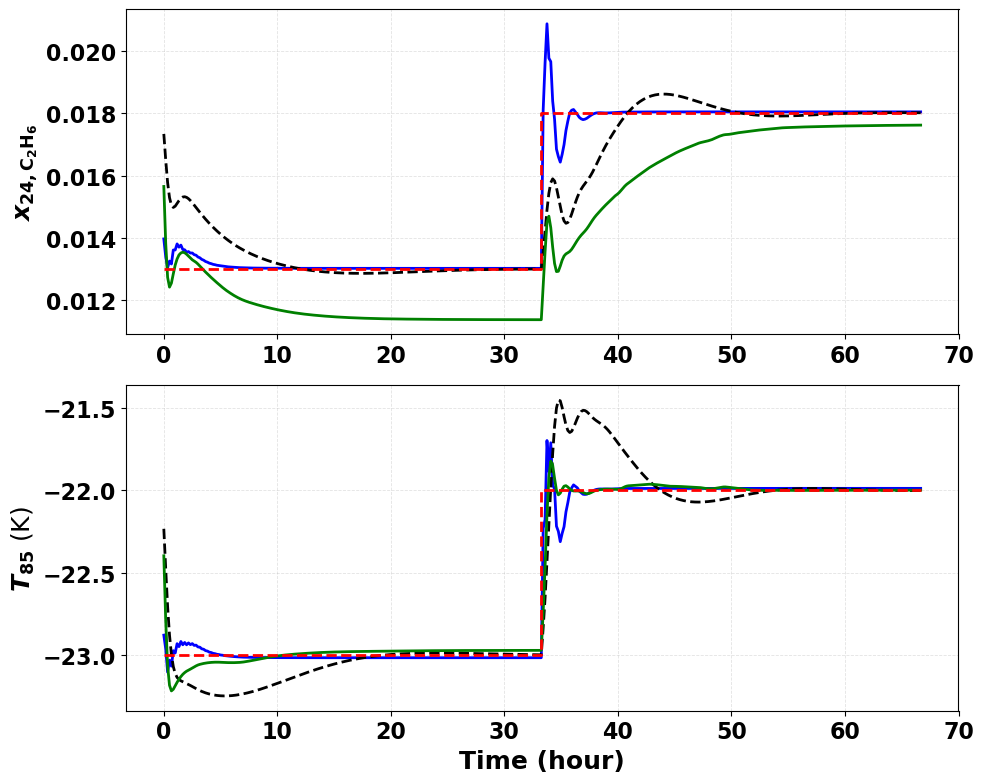

In [109]:
compare_mpc_rl_rl1(y_system, y_mpc, y_sp, time_in_sub_episodes, delta_t, y_system1)

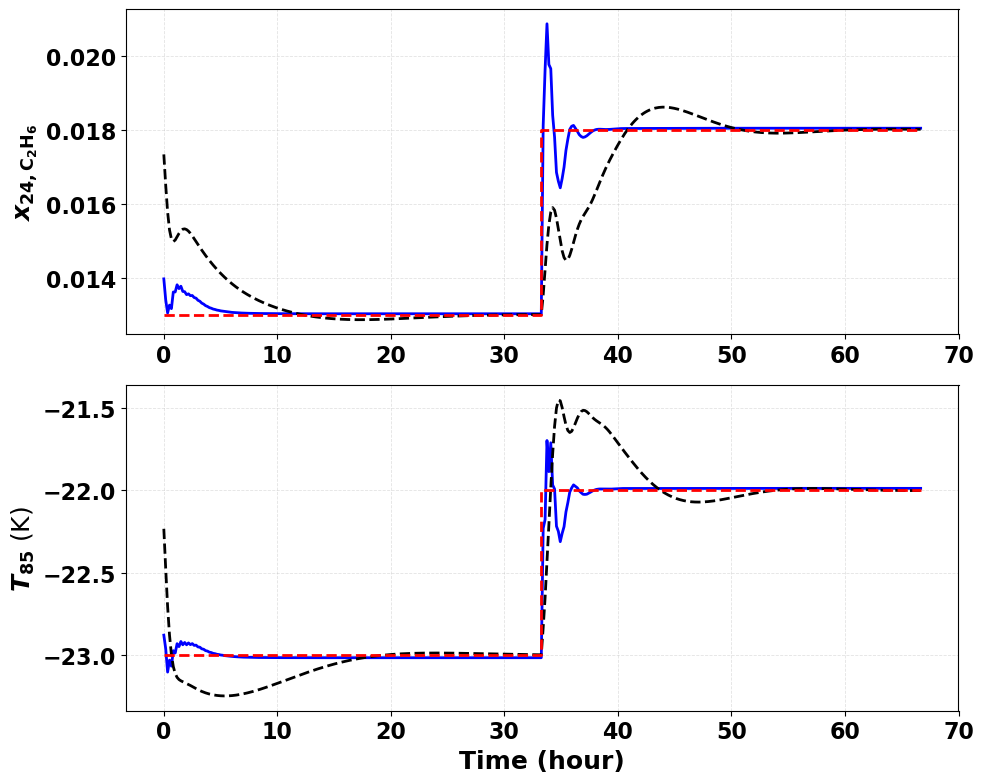

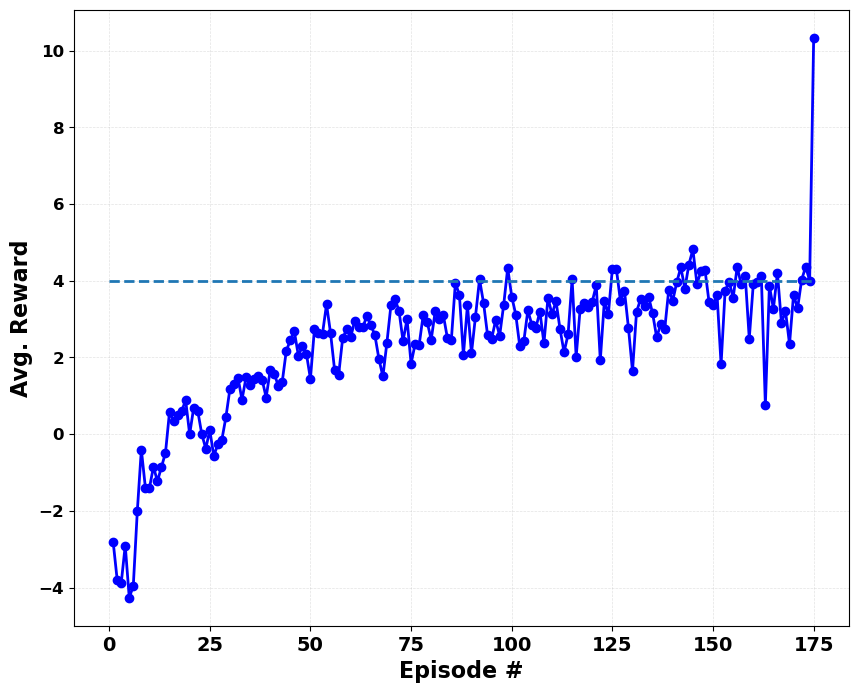

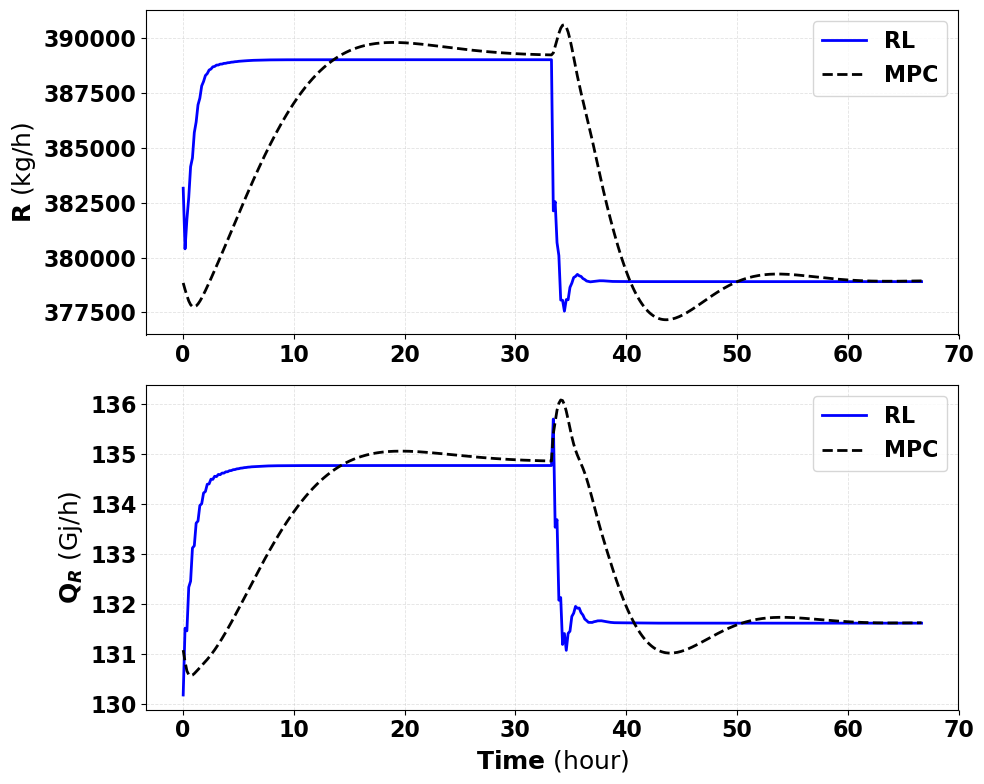

In [110]:
# save_path = os.path.join(dir_path, "mpc_results_RL_compare.pickle")
# with open(save_path, 'rb') as file:
#     mpc_results = pickle.load(file)
y_mpc = mpc_results["y_mpc"]
u_mpc = mpc_results["u_mpc"]
xhatdhat_mpc = mpc_results["xhatdhat"]
avg_rewards_mpc = mpc_results["avg_rewards"]
compare_mpc_rl_disturbance(y_system, y_mpc, y_sp, u_mpc, u_rl, avg_rewards, avg_reward_mpc_, time_in_sub_episodes, delta_t)